# Wumpus World Unity Environment Log Analysis

This notebook contains our analysis of performance logs from different AI agent implementations in the Wumpus World Unity environment.

We compare execution times and behavioral patterns across multiple scenarios with varying complexity.

## Context

The analysis focuses on different AI types including:
- Basic Rule-based agents
- Finite State Machine agents
- Behavior Tree agents
- Prolog agents
- Prolog Meta Interpreter agents

Each scenario uses different configurations of world size, number of agents, and dangers (pits and Wumpus) distribution.

### Common Parameters Across All Configurations

| Parameter | Value |
|:----------|:------|
| **randomSeed** | 1 |
| **nbGold** | 1 |
| **nbAgent** | [1, 5, 10] |
| **aiType** | [Basic, FiniteStateMachine, BehaviorTree, Prolog, PrologMetaInterpreter] |
| **personalities** | [Cupid-Brave, Ascetic-Coward, Cupid-Coward] |

The decision logic is the same across all AI implementations, leading to the same exploration patterns.


There are very small differences in step counts due to the way the AI types are implemented and the actions taken are collected.

### Grid-Specific Configurations

| Grid Size | Number of Cells | Number of Pits & Wumpus |
|:---------:|:---------------:|:-----------------------:|
| 10x10     | 100             | 3                       |
| 15x15     | 225             | 7                       |
| 20x20     | 400             | 12                      |
| 25x25     | 625             | 19                      |
| 30x30     | 900             | 27                      |
| 50x50     | 2500            | 75                      |
| 100x100   | 10000           | 300                     |

We have 7 grid sizes, 3 personality sets, 5 AI types, and 3 agent numbers.

So, there are `7*3*5*3=315` configurations.

#### Prolog Meta Interpreter Limitations
We have 45 files for 10x10, 15x15, 20x20, and 25x25 grids, but only 36 files for 30x30, 50x50, and 100x100 grids because the Prolog Meta Interpreter agent algorithm was too heavy on resources making Unity crash.

Then, to be fair in the analysis, we will only consider the first 4 grid sizes (10x10, 15x15, 20x20, and 25x25).

### Data Collection

Files are stored in the `data` directory (same as this file). The data is organized in subdirectories based on the grid size:
- 10x10
- 15x15
- 20x20
- 25x25
- 30x30
- 50x50
- 100x100

Each json file follows the naming convention:
```
<grid_size>_<nb_agents>_<nb_wumpus_pits>_<nb_gold>_<personality1>_<personality2>_<ai_type>.json
```

For example, for a 10x10 grid with 1 agent, 3 wumpus/pits, and 1 gold, using the Cupid and Coward personalities with a Basic AI type, the file would be in folder `10x10` under the name:
```
10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json
```

### Data Structure

Each JSON file contains an array with two objects:

1. **Game Configuration and Performance Data**:
    - `randomSeed`: The seed used for randomization
    - `gridMin` & `gridMax`: Boundaries of the grid
    - `tileSize`: Size of each tile
    - `nbPit`, `nbWumpus`, `nbGold`: Number of pits, wumpuses, and gold
    - `nbAgent`: Number of agents
    - `aiType`: Type of AI used (Basic, Prolog, BehaviorTree, etc.)
    - `personalities`: Array of personality type IDs
    - `isGameOver`: Whether the game has ended
    - `isModeAuto`: Whether the game is running in automatic mode
    - `turnDuration`: Array of turn durations in milliseconds

2. **Agent Behavior Data**:
    - `agent`: Agent identifier
    - `actions`: Array of actions taken by the agent
    - `positions`: Array of position objects, with x,y coordinates for each turn

See [10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json](10x10/10x10-1a-3wp-1g-Cupid-Coward-Basic.json) for an example of the data structure.

## 1. Performance Analysis Overview

This section focuses on analyzing the performance of different AI agent implementations within the Wumpus World environment. We analyze JSON log files from four grid sizes (10x10, 15x15, 20x20, 25x25) to establish comprehensive performance metrics.

Key metrics analyzed in this section:
- **Turn Duration**: The average time each agent takes to decide and execute an action, measured in milliseconds
- **Total Execution Time**: The cumulative time for the entire execution of the game, from start to finish
- **Steps Taken**: The total number of movements made by agents

The analysis compares these metrics across:
1. Different AI types (Basic, Finite State Machine, Behavior Tree, Prolog, Prolog Meta Interpreter)
2. Varying numbers of agents (1, 5, 10)
3. Different personality combinations (Cupid-Brave, Ascetic-Coward, Cupid-Coward)
4. Four grid sizes with increasing complexity

The visualizations reveal performance patterns and trade-offs between different agent implementations, with particular focus on computational efficiency, scalability, and exploration strategies.

In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import re
import pandas as pd
import seaborn as sns
from glob import glob
from matplotlib.ticker import ScalarFormatter

# Enhanced plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

# Custom color palette for AI types
ai_colors = {
    'Basic': '#1f77b4',  # Bright Blue
    'FiniteStateMachine': '#ff7f0e',  # Bright Orange
    'BehaviorTree': '#2ca02c',  # Bright Green
    'Prolog': '#d62728',  # Bright Red
    'PrologMetaInterpreter': '#9467bd'  # Bright Purple
}

# Custom colors for personalities
personality_colors = {
    'Cupid-Brave': '#e74c3c',  # Bright Red
    'Ascetic-Coward': '#3498db',  # Bright Blue
    'Cupid-Coward': '#f39c12'  # Bright Orange
}

# Global plotting parameters
plt.rcParams.update({
    'font.size': 12,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'axes.spines.top': False,
    'axes.spines.right': False,
    'axes.grid': True,
    'grid.alpha': 0.3
})


# Keep the existing functions
def load_json_data(file_path):
    """Load data from a JSON file."""
    with open(file_path, "r") as f:
        return json.load(f)


def get_turn_duration_stats(data):
    """Extract turn duration statistics from game data."""
    turn_durations = data[0]["turnDuration"]
    return {
        "mean": np.mean(turn_durations),
        "median": np.median(turn_durations),
        "min": np.min(turn_durations),
        "max": np.max(turn_durations),
        "std": np.std(turn_durations),
        "total": np.sum(turn_durations),
        "count": len(turn_durations),
    }


def analyze_agent_actions(data):
    """Analyze the frequency of different actions taken by agent."""
    actions = data[1]["actions"]
    action_counts = {}
    for action in actions:
        if action in action_counts:
            action_counts[action] += 1
        else:
            action_counts[action] = 1
    return action_counts


# Define function to calculate movement efficiency
def calculate_movement_efficiency(positions):
    total_steps = len(positions) - 1
    unique_positions = len(set((pos["x"], pos["y"]) for pos in positions))
    return {
        "total_steps": total_steps,
        "unique_positions": unique_positions
    }


# Function to parse file name to extract metadata
def parse_filename(filename):
    # Using regex to extract parts from filename
    pattern = r"(\d+)x\d+-(\d+)a-\d+wp-\d+g-(\w+)-(\w+)-(\w+).json"
    match = re.search(pattern, filename)
    if match:
        grid_size = match.group(1)
        num_agents = match.group(2)
        trait1 = match.group(3)
        trait2 = match.group(4)
        ai_type = match.group(5)
        return {
            "grid_size": int(grid_size),
            "num_cells": int(grid_size) ** 2,  # Add number of cells calculation
            "num_agents": int(num_agents),
            "trait1": trait1,
            "trait2": trait2,
            "ai_type": ai_type,
            "personality": f"{trait1}-{trait2}",
        }
    return None


# Load data from all grid sizes
all_data = {}
metadata = []

# Process files from all grid sizes
for grid_size in [10, 15, 20, 25]:
    # Use glob to find all .json files in each grid size directory
    grid_file_paths = glob(f"{grid_size}x{grid_size}/*.json")
    
    # Sort the file paths for consistent processing
    grid_file_paths.sort()
    
    print(f"Found {len(grid_file_paths)} files in {grid_size}x{grid_size} directory")
    
    # Process files and extract metadata
    for file_path in grid_file_paths:
        meta = parse_filename(file_path)
        if meta:
            data = load_json_data(file_path)

            # Collect stats
            turn_stats = get_turn_duration_stats(data)
            action_counts = analyze_agent_actions(data)
            movement_efficiency = calculate_movement_efficiency(data[1]["positions"])

            # Store all info
            file_key = (
                f"{meta['grid_size']}x{meta['grid_size']}-{meta['num_agents']}a-{meta['trait1']}-{meta['trait2']}-{meta['ai_type']}"
            )
            all_data[file_key] = {
                "data": data,
                "meta": meta,
                "stats": {
                    "turn_stats": turn_stats,
                    "action_counts": action_counts,
                    "movement_efficiency": movement_efficiency,
                },
            }

            # Add stats to metadata for DataFrame
            meta_entry = {
                **meta,
                "mean_turn": turn_stats["mean"],
                "median_turn": turn_stats["median"],
                "max_turn": turn_stats["max"],
                "total_time": turn_stats["total"],
                "steps": movement_efficiency["total_steps"],
                "actions": len(action_counts)
            }
            metadata.append(meta_entry)

# Create DataFrame for easier analysis
df = pd.DataFrame(metadata)
print(f"Processed a total of {len(metadata)} files across all grid sizes")
print(f"Grid sizes in dataset (nb of cells): {[int(cells) for cells in sorted(df['num_cells'].unique())]}")
print(f"AI types in dataset: {sorted(df['ai_type'].unique())}")

print(f"Personalities in dataset: {sorted(df['personality'].unique())}")

Found 45 files in 10x10 directory
Found 45 files in 15x15 directory
Found 45 files in 20x20 directory
Found 45 files in 25x25 directory
Processed a total of 180 files across all grid sizes
Grid sizes in dataset (nb of cells): [100, 225, 400, 625]
AI types in dataset: ['Basic', 'BehaviorTree', 'FiniteStateMachine', 'Prolog', 'PrologMetaInterpreter']
Personalities in dataset: ['Ascetic-Coward', 'Cupid-Brave', 'Cupid-Coward']


## 2. Mean Turn Duration by Grid Size and AI Type

This boxplot compares the distribution of average decision times across different AI implementations and grid sizes. The analysis reveals significant performance differences:

**Key Observations:**
- **Basic, FSM, and BehaviorTree** agents maintain consistently low decision times (~1 ms) across all grid sizes
- **Prolog** agents show moderate decision times (~10 ms) with minimal variation across grid complexity
- **PrologMetaInterpreter** exhibits the highest decision times (~128 ms), demonstrating the computational overhead of meta-interpretation
- Decision time performance remains relatively stable across different grid sizes for all AI types
- The performance hierarchy clearly distinguishes procedural approaches from logic-based implementations

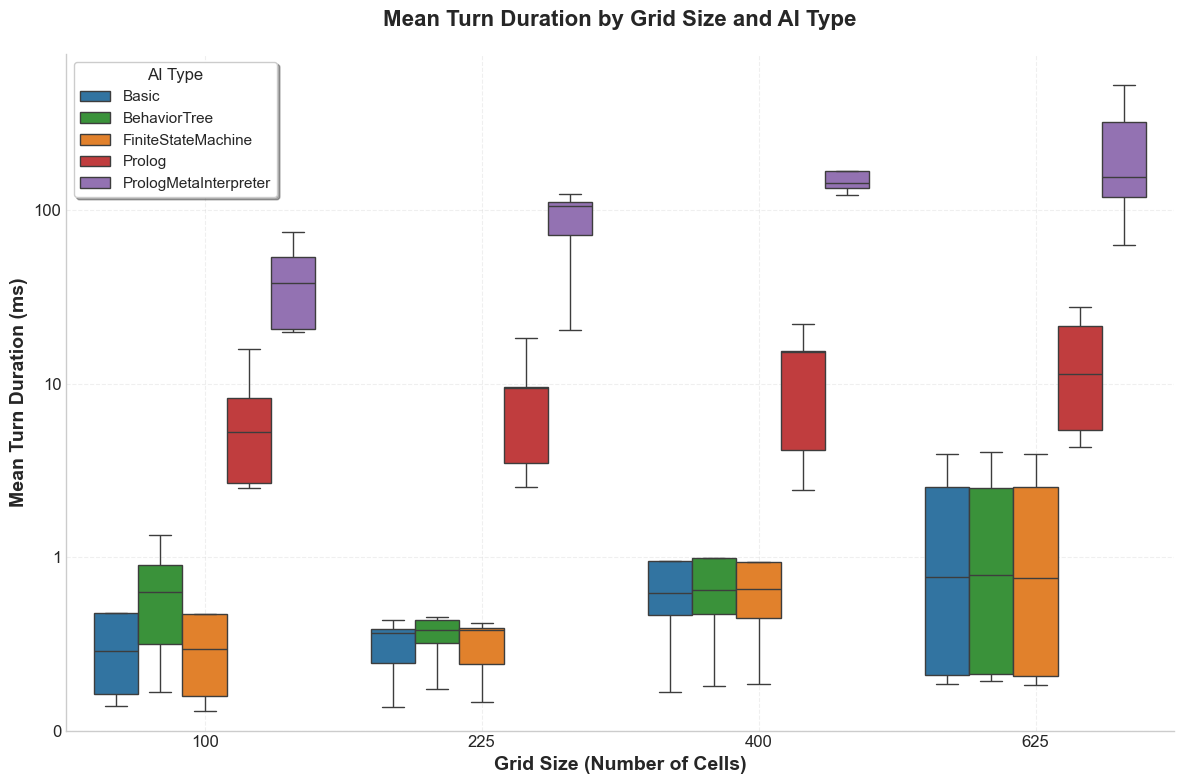

In [2]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="num_cells", y="mean_turn", hue="ai_type", data=df, 
                 showfliers=False, palette=ai_colors)
plt.title("Mean Turn Duration by Grid Size and AI Type", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("Grid Size (Number of Cells)", fontweight='bold')
plt.ylabel("Mean Turn Duration (ms)", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(bottom=0.1)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('./figures/grid_size_ai_type_mean_turn.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 3. Total Execution Time by Grid Size and AI Type

This bar chart illustrates the cumulative processing time required by different AI implementations across various grid sizes. The analysis reveals dramatic scalability differences:

**Key Observations:**
- **Basic, FSM, and BehaviorTree** agents maintain sub-second execution times across all grid sizes, demonstrating excellent scalability
- **Prolog** agents show moderate increases in execution time, ranging from ~270 ms to ~2.6 seconds as grid size increases
- **PrologMetaInterpreter** exhibits exponential scaling issues, jumping from ~1.8 seconds on 10x10 grids to over 106 seconds on 25x25 grids
- The performance gap between procedural and logic-based AIs grows dramatically with grid complexity
- Total execution time scales super-linearly with grid size for all AI types, but logic-based approaches are disproportionately affected

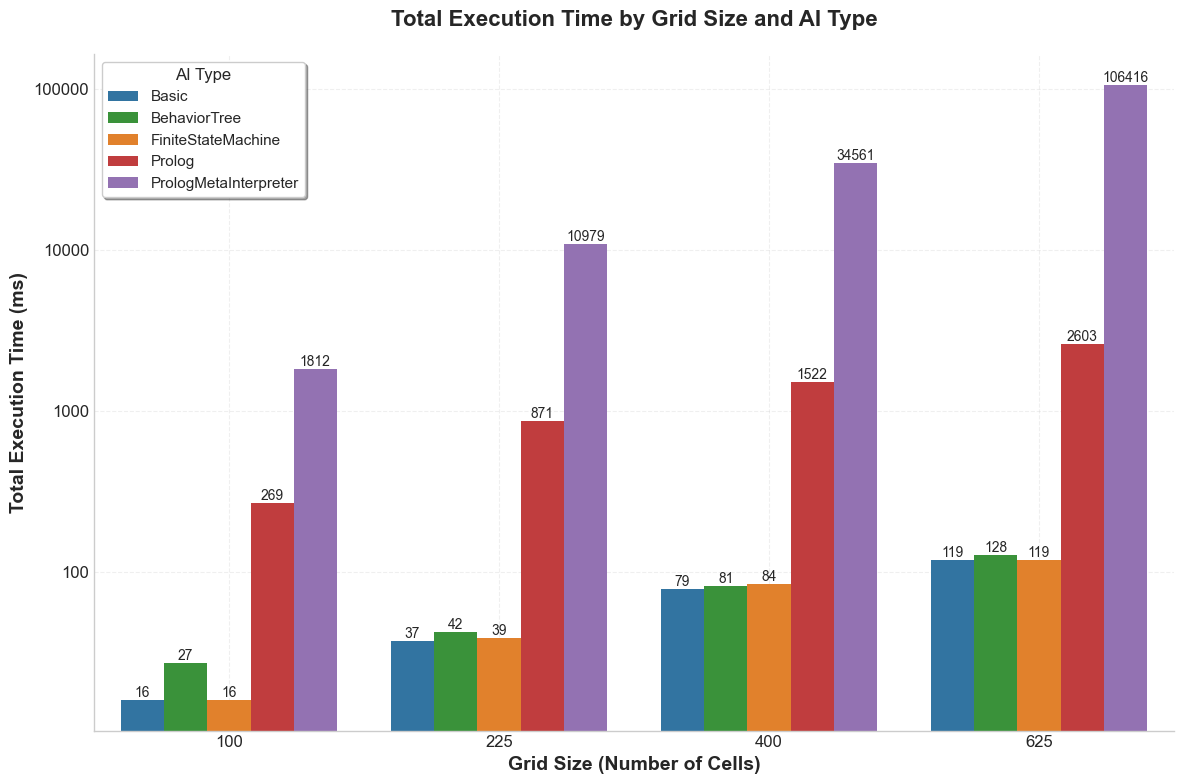

In [3]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="num_cells", y="total_time", hue="ai_type", data=df, 
                 errorbar=None, palette=ai_colors)
plt.title("Total Execution Time by Grid Size and AI Type", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("Grid Size (Number of Cells)", fontweight='bold')
plt.ylabel("Total Execution Time (ms)", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('./figures/grid_size_ai_type_total_time.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 4. Mean Steps by Grid Size and AI Type

This bar chart displays the average number of steps taken by agents across different grid sizes and AI implementations. The analysis confirms uniform exploration behavior across AI types:

**Key Observations:**
- **All AI types** take virtually identical numbers of steps, confirming that the same decision logic is implemented across different AI architectures
- **Grid size correlation**: Steps scale almost linearly with grid area (62 steps for 100 cells → 365 steps for 625 cells)
- **Efficiency indicator**: The near-identical step counts validate that performance differences observed in previous charts are purely computational, not behavioral
- **Exploration consistency**: Minor variations (±1-2 steps) are due to implementation differences in action collection rather than strategic differences
- **Scalability validation**: The linear relationship between grid size and required steps provides a baseline for evaluating computational efficiency

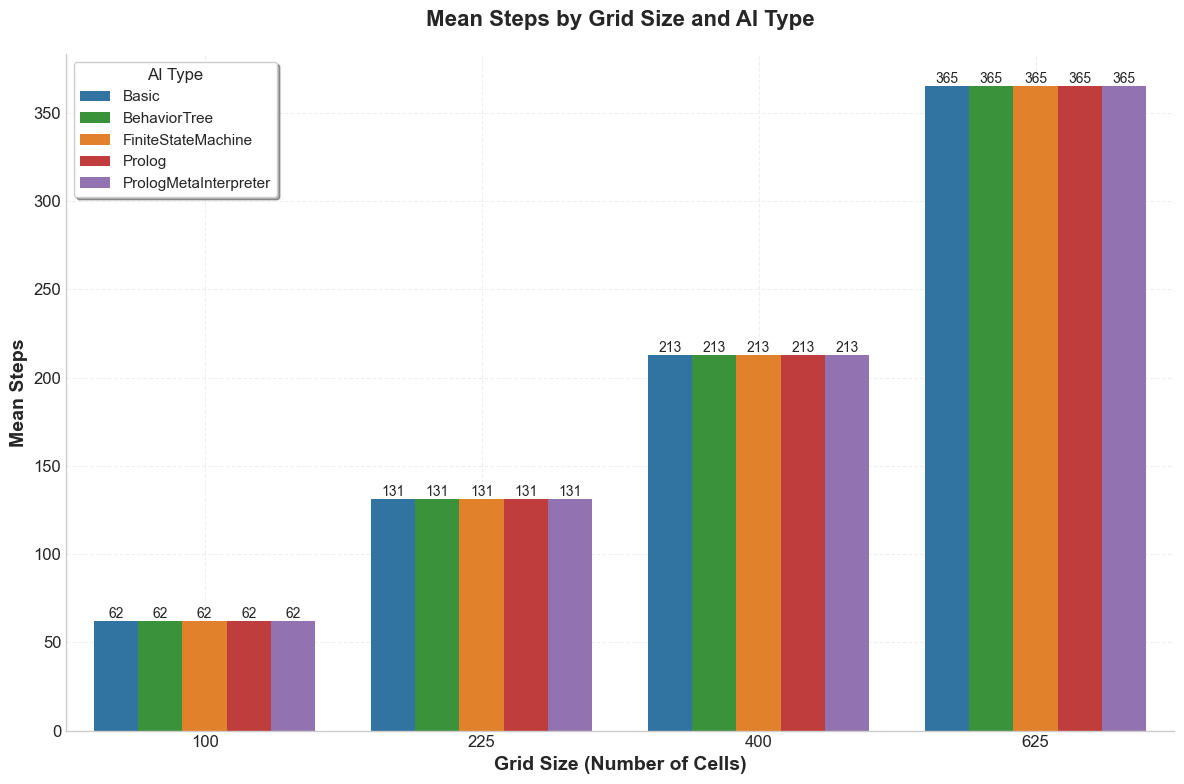

In [4]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="num_cells", y="steps", hue="ai_type", data=df, 
                 errorbar=None, palette=ai_colors)
plt.title("Mean Steps by Grid Size and AI Type", 
          fontweight='bold', pad=20)
plt.xlabel("Grid Size (Number of Cells)", fontweight='bold')
plt.ylabel("Mean Steps", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('./figures/grid_size_ai_type_steps.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 5. Mean Turn Duration by Agent Count and AI Type

This boxplot examines how the number of agents affects average decision times across different AI implementations. The analysis reveals interesting coordination patterns:

**Key Observations:**
- **Coordination overhead**: Mean turn duration increases with agent count (1 agent: ~20.6 ms → 10 agents: ~35.6 ms)
- **Consistent AI hierarchy**: PrologMetaInterpreter remains the slowest across all agent counts, while Basic/FSM/BehaviorTree maintain efficiency
- **Scalability patterns**: Logic-based AIs show more pronounced increases in decision time as agent coordination complexity grows
- **Multi-agent impact**: The 40-72% increase in per-turn decision time reflects the computational cost of coordinating multiple agents
- **Performance distribution**: Boxplot variance increases with agent count, suggesting more variable performance under multi-agent scenarios

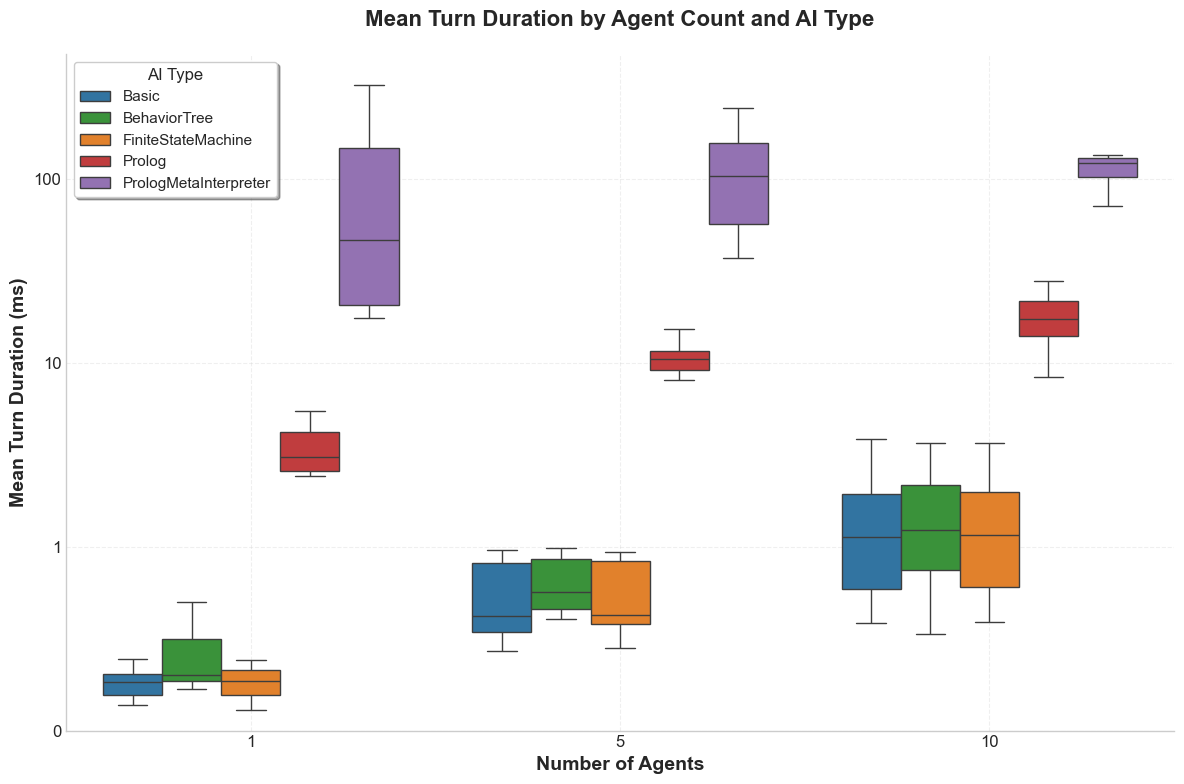

In [5]:
plt.figure(figsize=(12, 8))
ax = sns.boxplot(x="num_agents", y="mean_turn", hue="ai_type", data=df, 
                 showfliers=False, palette=ai_colors)
plt.title("Mean Turn Duration by Agent Count and AI Type", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("Number of Agents", fontweight='bold')
plt.ylabel("Mean Turn Duration (ms)", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(bottom=0.1)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('./figures/agent_count_ai_type_mean_turn.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 6. Total Execution Time by Agent Count and AI Type

This bar chart analyzes how the number of agents affects total execution time across different AI implementations. The results demonstrate the benefits of parallel exploration:

**Key Observations:**
- **Parallel efficiency**: Total execution time decreases dramatically with more agents (1 agent: ~14.8 seconds → 10 agents: ~3.5 seconds)
- **Workload distribution**: More agents share exploration tasks, leading to faster overall completion despite higher per-turn coordination costs
- **AI type consistency**: All AI types benefit from multi-agent parallelization, maintaining their relative performance hierarchy
- **Optimal scaling**: 76% reduction in total time with 10 agents vs. 1 agent demonstrates effective parallel exploration
- **Coordination vs. efficiency trade-off**: Despite increased per-turn overhead, the benefits of distributed exploration significantly outweigh coordination costs

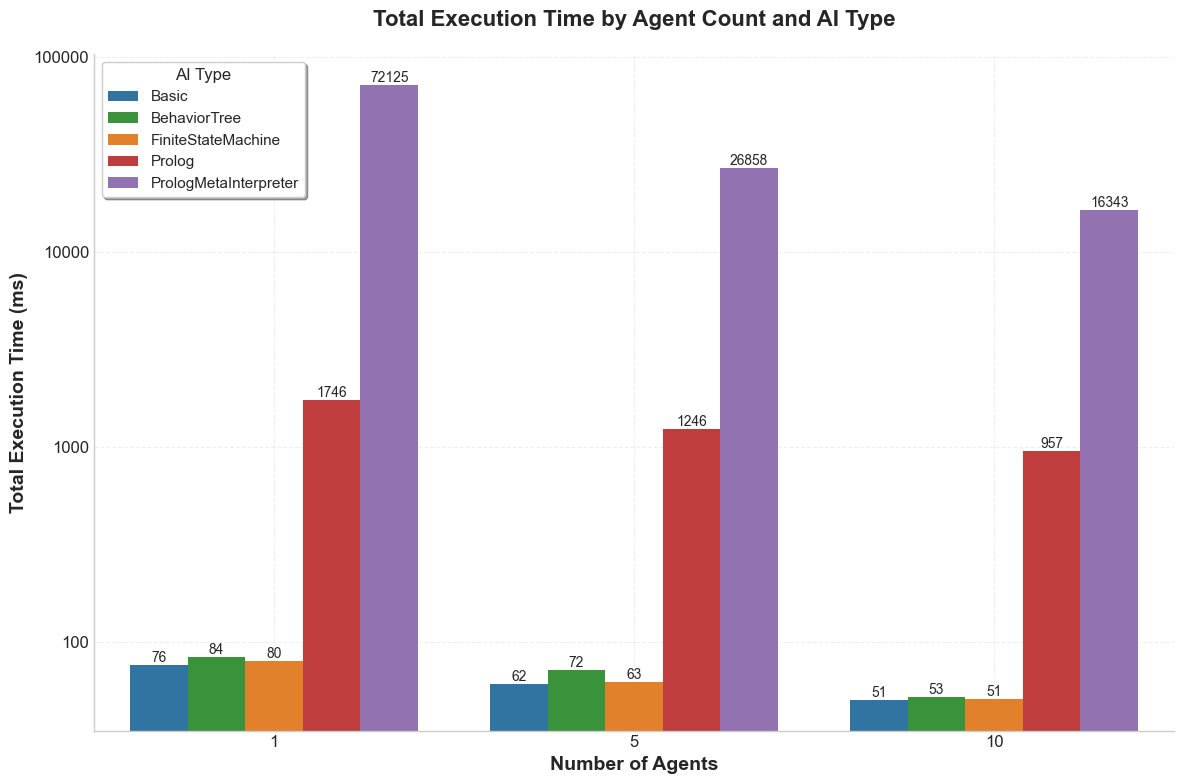

In [6]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="num_agents", y="total_time", hue="ai_type", data=df, 
                 errorbar=None, palette=ai_colors)
plt.title("Total Execution Time by Agent Count and AI Type", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("Number of Agents", fontweight='bold')
plt.ylabel("Total Execution Time (ms)", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('./figures/agent_count_ai_type_total_time.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 7. Mean Steps by Agent Count and AI Type

This bar chart examines how the number of agents affects the total number of steps required for mission completion. The analysis reveals the efficiency gains of multi-agent exploration:

**Key Observations:**
- **Dramatic step reduction**: Total steps decrease significantly with more agents (1 agent: ~405 steps → 10 agents: ~60 steps)
- **Per-agent efficiency**: Individual agents take fewer steps when working in teams due to shared exploration workload
- **Consistent behavior**: All AI types show identical step patterns, confirming uniform exploration logic implementation
- **Optimal team size**: 85% reduction in total steps with 10 agents vs. 1 agent demonstrates the value of collaborative exploration
- **Grid coverage efficiency**: Multiple agents can cover different grid areas simultaneously, minimizing redundant exploration

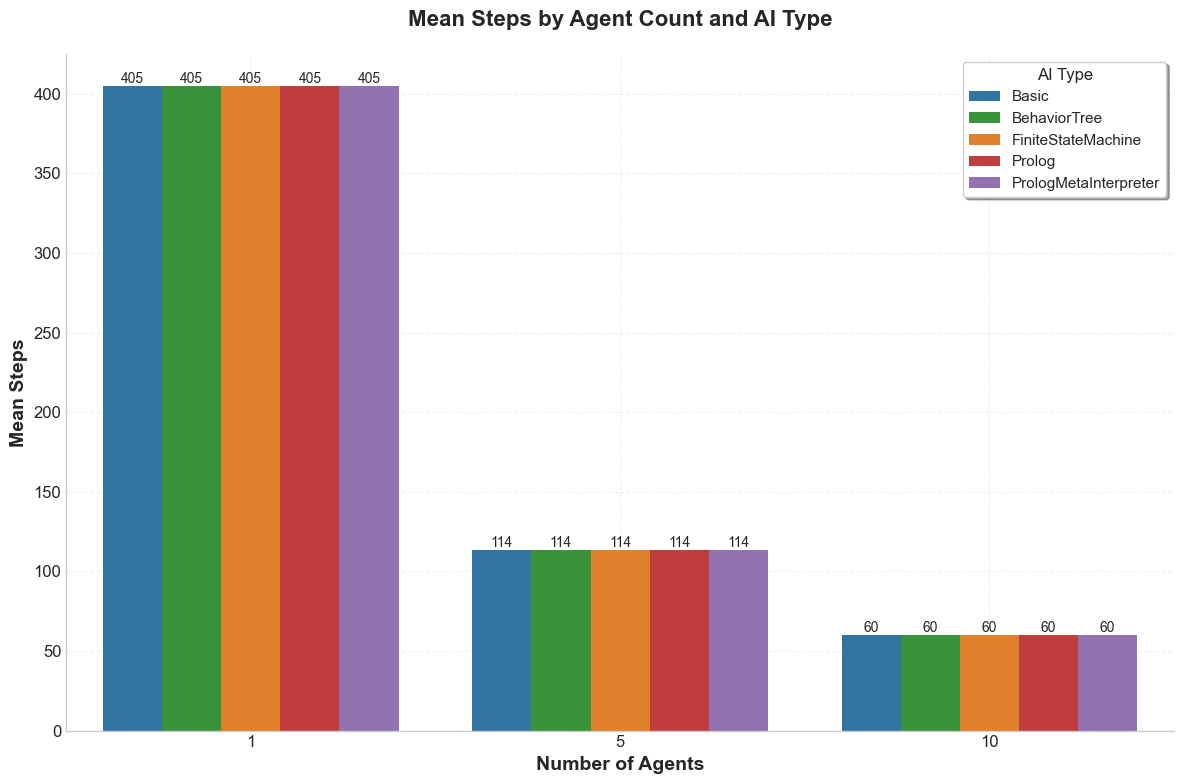

In [7]:
plt.figure(figsize=(12, 8))
ax = sns.barplot(x="num_agents", y="steps", hue="ai_type", data=df, 
                 errorbar=None, palette=ai_colors)
plt.title("Mean Steps by Agent Count and AI Type", 
          fontweight='bold', pad=20)
plt.xlabel("Number of Agents", fontweight='bold')
plt.ylabel("Mean Steps", fontweight='bold')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='AI Type', title_fontsize=12, 
          loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt='%.0f', fontsize=10, rotation=0)

plt.tight_layout()
plt.savefig('./figures/agent_count_ai_type_steps.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 8. Mean Steps by AI Type and Personality

This boxplot analyzes the interaction between AI implementation and personality traits on exploration behavior. The analysis reveals significant personality-driven differences in exploration patterns:

**Key Observations:**
- **Personality hierarchy**: Ascetic-Coward agents take the most steps (~294), followed by Cupid-Coward (~177), then Cupid-Brave (~108)
- **Risk-taking behavior**: Brave personalities show more efficient exploration, taking fewer steps to complete missions
- **Coward patterns**: Coward personalities require more exploration steps, likely due to cautious avoidance behaviors
- **AI type consistency**: All AI implementations show identical step patterns within each personality type, confirming uniform decision logic
- **Behavioral variance**: The boxplot spread indicates some variability in exploration efficiency even within personality-AI combinations

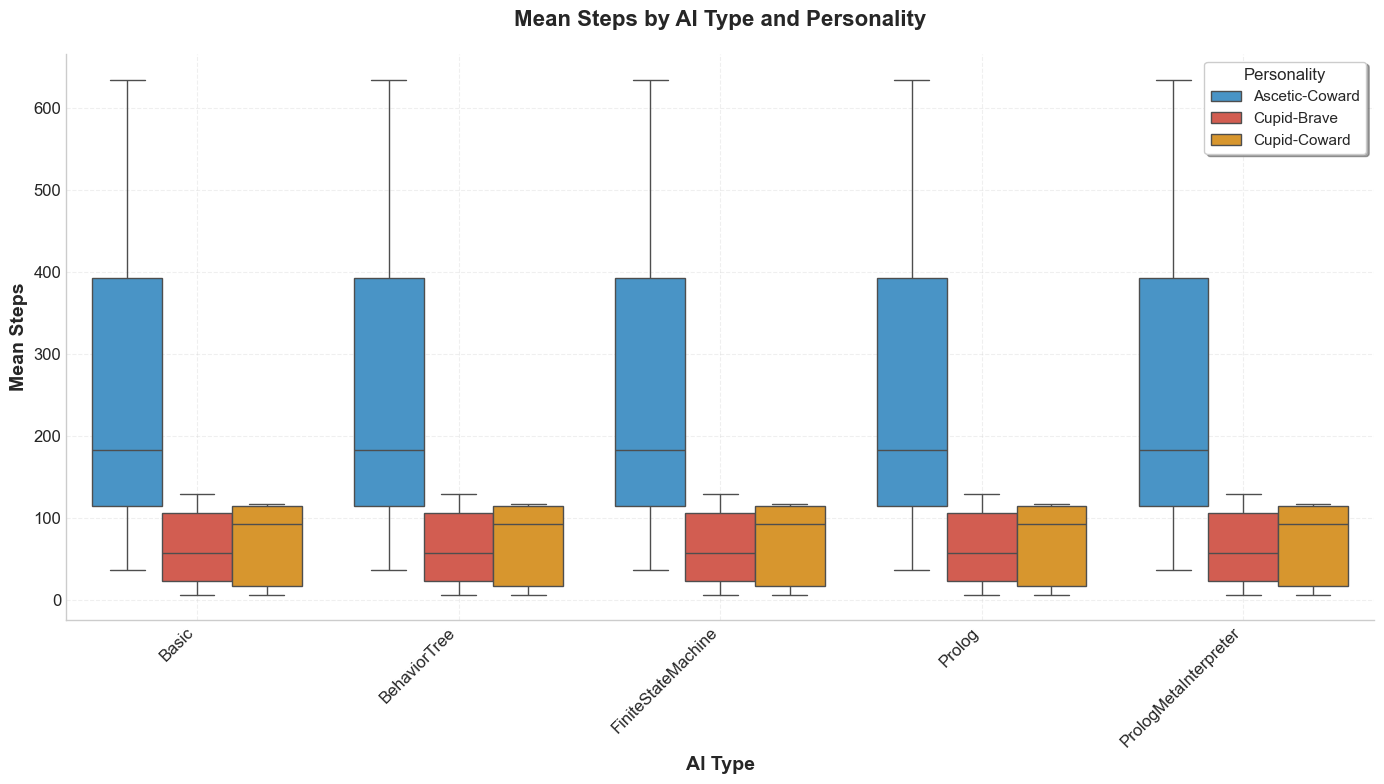

In [8]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="ai_type", y="steps", hue="personality", data=df, 
                 showfliers=False, palette=personality_colors)
plt.title("Mean Steps by AI Type and Personality", 
          fontweight='bold', pad=20)
plt.xlabel("AI Type", fontweight='bold')
plt.ylabel("Mean Steps", fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Personality', title_fontsize=12, 
          loc='upper right', frameon=True, fancybox=True, shadow=True)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('./figures/interaction_ai_personality.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 9. Mean Turn Duration by AI Type and Personality

This boxplot analyzes the interaction between AI implementation and personality traits on decision-making speed. The analysis reveals how personality affects computational performance across different AI architectures:

**Key Observations:**
- **AI type hierarchy maintained**: PrologMetaInterpreter remains the slowest across all personalities, while Basic/FSM/BehaviorTree maintain efficiency
- **Personality impact on performance**: Different personalities may show slight variations in decision time due to different exploration patterns
- **Computational consistency**: The relative performance differences between AI types remain consistent regardless of personality traits
- **Decision complexity**: More cautious personalities (Coward types) may require slightly more computation time for risk assessment
- **Performance distribution**: Boxplot variance shows how personality traits interact with AI computational overhead


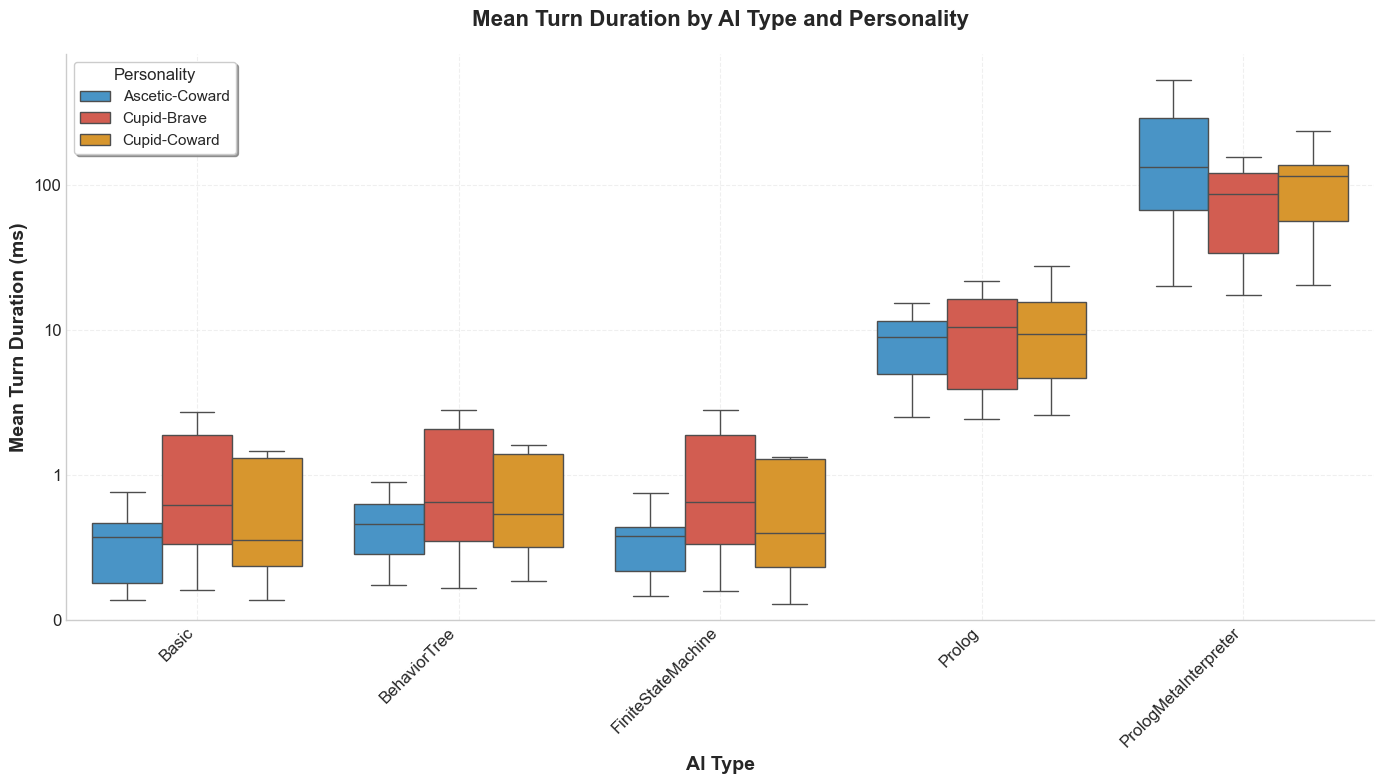

In [10]:
plt.figure(figsize=(14, 8))
ax = sns.boxplot(x="ai_type", y="mean_turn", hue="personality", data=df, 
                 showfliers=False, palette=personality_colors)
plt.title("Mean Turn Duration by AI Type and Personality", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("AI Type", fontweight='bold')
plt.ylabel("Mean Turn Duration (ms)", fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Personality', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())
ax.set_ylim(bottom=0.1)

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

plt.tight_layout()
plt.savefig('./figures/ai_type_personality_mean_turn.pdf', dpi=300, bbox_inches='tight')
plt.show()


## 10. Total Execution Time by AI Type and Personality

This bar chart examines how personality traits affect total execution time across different AI implementations. The analysis reveals the combined impact of computational overhead and exploration efficiency:

**Key Observations:**
- **Personality-driven efficiency**: Brave personalities typically show faster total execution times due to more direct exploration paths
- **Coward penalty**: Coward personalities require longer total execution times due to cautious exploration patterns requiring more steps
- **AI type consistency**: The relative performance hierarchy between AI types remains consistent across all personality combinations
- **Compound effects**: Total execution time reflects both per-turn computational cost and the number of turns required based on personality-driven behavior
- **Scalability patterns**: Logic-based AIs show more pronounced increases in execution time, especially when combined with cautious personality traits


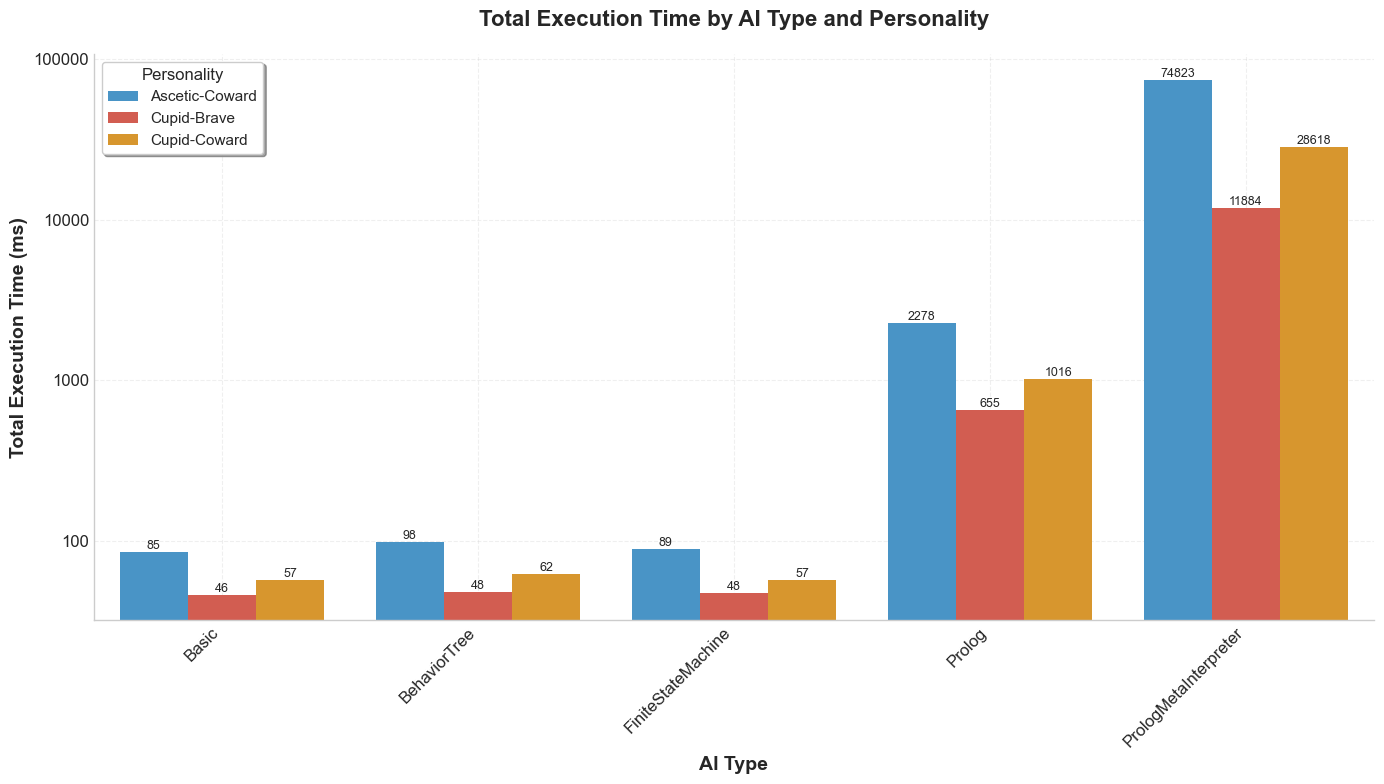

In [12]:
plt.figure(figsize=(14, 8))
ax = sns.barplot(x="ai_type", y="total_time", hue="personality", data=df, 
                 errorbar=None, palette=personality_colors)
plt.title("Total Execution Time by AI Type and Personality", 
          fontweight='bold', pad=20)
plt.yscale("log")
plt.xlabel("AI Type", fontweight='bold')
plt.ylabel("Total Execution Time (ms)", fontweight='bold')

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Customize legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title='Personality', title_fontsize=12, 
          loc='upper left', frameon=True, fancybox=True, shadow=True)

# Format y-axis to show actual values on log scale
ax.yaxis.set_major_formatter(ScalarFormatter())

# Add grid
ax.grid(True, alpha=0.3, linestyle='--')

# Add value labels on bars for better readability
for container in ax.containers:
    ax.bar_label(container, fmt="%.0f", fontsize=9)

plt.tight_layout()
plt.savefig('./figures/ai_type_personality_total_time.pdf', dpi=300, bbox_inches='tight')
plt.show()

## 11. Performance Metrics Summary Tables

The following summary tables provide comprehensive performance metrics across different dimensions of the analysis:

In [13]:
print("Summary of Performance Metrics by AI Type:")
ai_summary = (
    df.groupby("ai_type")
    .agg(
        {
            "mean_turn":   "mean",
            "median_turn": "mean",
            "total_time":  "mean",
            "steps":       "mean",
        }
    )
    .reset_index()
)
ai_summary = ai_summary.rename(
    columns={
        "ai_type": "AI Type",
        "mean_turn": "Mean Turn Duration (ms)",
        "median_turn": "Median Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(ai_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Turn Duration by Grid Size:")
mean_grid_summary = df.groupby("num_cells").agg({"mean_turn": "mean"}).reset_index()

# Add mean turn time (in ms) for each AI type
mean_time_by_ai = df.pivot_table(
    index="num_cells", columns="ai_type", values="mean_turn", aggfunc="mean"
).reset_index()

mean_grid_summary = mean_grid_summary.merge(mean_time_by_ai, on="num_cells")

# Move overall mean_time to be the last column
cols = [c for c in mean_grid_summary.columns if c != "mean_turn"] + ["mean_turn"]
mean_grid_summary = mean_grid_summary[cols]

mean_grid_summary = mean_grid_summary.rename(
    columns={
        "num_cells": "Grid Size",
        "mean_turn": "Mean Turn Duration (ms)",
    }
)
print(mean_grid_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Execution Time by Grid Size:")
total_grid_summary = (
    df.groupby("num_cells")
    .agg(
        {
            "steps":     "mean",
            "total_time": "mean",
        }
    )
    .reset_index()
)

# Add total execution time (in ms) for each AI type
total_time_by_ai = df.pivot_table(
    index="num_cells", columns="ai_type", values="total_time", aggfunc="mean"
).reset_index()

total_grid_summary = total_grid_summary.merge(total_time_by_ai, on="num_cells")

# Move overall total_time to be the last column
cols = [c for c in total_grid_summary.columns if c != "total_time"] + ["total_time"]
total_grid_summary = total_grid_summary[cols]

total_grid_summary = total_grid_summary.rename(
    columns={
        "num_cells": "Grid Size",
        "steps": "Mean Steps",
        "total_time": "Mean Execution Time (ms)",
    }
)
print(total_grid_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Number of Agents:")
agent_summary = (
    df.groupby("num_agents")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
        }
    )
    .reset_index()
)

agent_summary = agent_summary.rename(
    columns={
        "num_agents": "Number of Agents",
        "mean_turn": "Mean Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary by Personality:")
personality_summary = (
    df.groupby("personality")
    .agg(
        {
            "mean_turn": "mean",
            "total_time": "mean",
            "steps": "mean",
        }
    )
    .reset_index()
)


personality_summary = personality_summary.rename(
    columns={
        "personality": "Personality",
        "mean_turn": "Mean Turn Duration (ms)",
        "total_time": "Mean Execution Time (ms)",
        "steps": "Mean Steps",
    }
)
print(personality_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Turn Duration by Number of Agents:")
mean_agent_summary = df.groupby("num_agents").agg({"mean_turn": "mean"}).reset_index()

# Add mean turn time (in ms) for each AI type
mean_turn_by_ai_agents = df.pivot_table(
    index="num_agents", columns="ai_type", values="mean_turn", aggfunc="mean"
).reset_index()

mean_agent_summary = mean_agent_summary.merge(mean_turn_by_ai_agents, on="num_agents")

# Move overall mean_turn to be the last column
cols = [c for c in mean_agent_summary.columns if c != "mean_turn"] + ["mean_turn"]
mean_agent_summary = mean_agent_summary[cols]

mean_agent_summary = mean_agent_summary.rename(
    columns={
        "num_agents": "Number of Agents",
        "mean_turn": "Mean Turn Duration (ms)",
    }
)
print(mean_agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

print("\nSummary for Mean Total Execution Time by Number of Agents:")
total_agent_summary = (
    df.groupby("num_agents")
    .agg(
        {
            "steps":     "mean",
            "total_time": "mean",
        }
    )
    .reset_index()
)

# Add total execution time (in ms) for each AI type
total_time_by_ai_agents = df.pivot_table(
    index="num_agents", columns="ai_type", values="total_time", aggfunc="mean"
).reset_index()

total_agent_summary = total_agent_summary.merge(total_time_by_ai_agents, on="num_agents")

# Move overall total_time to be the last column
cols = [c for c in total_agent_summary.columns if c != "total_time"] + ["total_time"]
total_agent_summary = total_agent_summary[cols]

total_agent_summary = total_agent_summary.rename(
    columns={
        "num_agents": "Number of Agents",
        "steps": "Mean Steps",
        "total_time": "Mean Total Execution Time (ms)",
    }
)
print(total_agent_summary.to_string(index=False, float_format=lambda x: f"{x:.2f}"))

Summary of Performance Metrics by AI Type:
              AI Type  Mean Turn Duration (ms)  Median Turn Duration (ms)  Mean Execution Time (ms)  Mean Steps
                Basic                     0.96                       0.34                     62.87      192.83
         BehaviorTree                     1.05                       0.36                     69.62      192.83
   FiniteStateMachine                     0.98                       0.34                     64.59      192.83
               Prolog                    10.33                      10.31                   1316.51      192.83
PrologMetaInterpreter                   128.39                     133.44                  38441.79      192.83

Summary for Mean Turn Duration by Grid Size:
 Grid Size  Basic  BehaviorTree  FiniteStateMachine  Prolog  PrologMetaInterpreter  Mean Turn Duration (ms)
       100   0.54          0.75                0.54    7.36                  41.61                    10.16
       225   0.38      

## 12. Comprehensive Performance Analysis Results

Our analysis of agent performance in the Wumpus World environment, incorporating all available files, reveals refined insights into the performance of different AI implementations. Below are the key findings:

#### AI Type Performance Comparison

1. **Computational Efficiency**
    - Basic: 0.96 ms/turn  
    - FiniteStateMachine: 0.98 ms/turn  
    - BehaviorTree: 1.05 ms/turn  
    - Prolog: 10.33 ms/turn (≈10× slower than Basic/FSM/BT)  
    - PrologMetaInterpreter: 128.39 ms/turn (≈128× slower than Basic/FSM/BT)

2. **Median Turn Duration**
    - Basic/FSM/BT cluster at ~0.34–0.36 ms
    - Prolog at 10.31 ms (≈30× slower than Basic/FSM/BT)
    - Meta‐Interpreter at 133.44 ms (≈400× slower than Basic/FSM/BT)

3. **Total Processing Time**
    - Basic: 62.87 ms
    - FSM: 64.59 ms
    - BT: 69.62 ms 
    - Prolog: 1 316.51 ms (≈20× slower than Basic/FSM/BT)
    - Meta‐Interpreter: 38 441.79 ms (≈600× slower than Basic/FSM/BT)

4. **Exploration Behavior**
    - All AI types traverse ~192.83 steps on average, confirming identical exploration logic across implementations.

#### Grid Size Impact

1. **Mean Steps by AI Type and Grid Size**

    | Grid Size | Basic  | BehaviorTree | FiniteStateMachine | Prolog | PrologMetaInterpreter | Mean Steps |
    |-----------|--------|--------------|--------------------|--------|-----------------------|------------|
    | **100**   | 62.00  | 62.00        | 62.00              | 62.00  | 62.00                 | **62.00**  |
    | **225**   | 131.44 | 131.44       | 131.44             | 131.44 | 131.44                | **131.44** |
    | **400**   | 212.78 | 212.78       | 212.78             | 212.78 | 212.78                | **212.78** |
    | **625**   | 365.11 | 365.11       | 365.11             | 365.11 | 365.11                | **365.11** |

    - All AI types traverse a nearly identical number of steps for each grid size, confirming uniform exploration logic.
    - The number of steps scales almost linearly with the grid area (a 6.25x increase in area from 10x10 to 25x25 results in a 5.9x increase in steps).

2. **Mean Turn Duration by AI Type and Grid Size**

    | AI Type                | 10×10 (ms) | 15×15 (ms) [2.25× vs. prev] (+% vs. prev) | 20×20 (ms) [1.78× vs. prev] (+% vs. prev) | 25×25 (ms) [1.56× vs. prev] (+% vs. prev) | (+% 10×10 → 25×25) |
    |---------------------------|------------|-------------------------------------------|-------------------------------------------|-------------------------------------------|---------------------|
    | **Basic AI**              | 0.54       | 0.38 (**−30%**)                           | 1.13 (**+197%**)                          | 1.79 (**+58%**)                           | **+231%**           |
    | **FSM**                   | 0.54       | 0.39 (**−28%**)                           | 1.14 (**+192%**)                          | 1.84 (**+61%**)                           | **+241%**           |
    | **BT**                    | 0.75       | 0.42 (**−44%**)                           | 1.14 (**+171%**)                          | 1.88 (**+65%**)                           | **+151%**           |
    | **Prolog**                | 7.36       | 8.31 (**+13%**)                           | 12.32 (**+48%**)                          | 13.31 (**+8%**)                           | **+81%**            |
    | **PrologMetaInterpreter** | 41.61      | 87.04 (**+109%**)                         | 155.43 (**+79%**)                         | 229.47 (**+48%**)                         | **+451%**           |
    | **Mean Turn Duration**    | 10.16      | 19.31 (**+90%**)                          | 34.23 (**+77%**)                          | 49.66 (**+45%**)                          | **+389%**           |

    - **Basic, FSM, and BT** maintain low per-turn durations and scale similarly, remaining much faster than Prolog and Meta-Interpreter at all grid sizes.
    - **Prolog** and especially **PrologMetaInterpreter** experience much higher per-turn durations, with Meta-Interpreter showing a super-linear increase as grid size grows.
    - The per-turn performance gap between logic-based and procedural AIs widens significantly as the environment size increases.


3. **Mean Total Execution Time by AI Type and Grid Size**

    | AI Type                    | 10×10 (ms) | 15×15 (ms) [2.25× vs. prev] (+% vs. prev) | 20×20 (ms) [1.78× vs. prev] (+% vs. prev) | 25×25 (ms) [1.56× vs. prev] (+% vs. prev) | (+% 10×10 vs. 25×25) |
    |----------------------------|------------|-------------------------------------------|-------------------------------------------|-------------------------------------------|----------------------|
    | **Basic AI**               | 16.09      | 37.45 (**+133%**)                             | 78.79 (**+110%**)                             | 119.16 (**+51%**)                             | **+641%**                |
    | **FSM**                    | 16.09      | 39.05 (**+143%**)                             | 83.97 (**+115%**)                             | 119.26 (**+42%**)                             | **+641%**                |
    | **BT**                     | 27.12      | 42.30 (**+56%**)                              | 81.47 (**+93%**)                              | 127.60 (**+57%**)                             | **+371%**                |
    | **Prolog**                 | 269.27     | 871.46 (**+224%**)                            | 1 522.27 (**+75%**)                           | 2 603.07 (**+71%**)                           | **+867%**                |
    | **PrologMetaInterpreter**  | 1 812.06   | 10 978.56 (**+506%**)                         | 34 560.77 (**+215%**)                         | 106 415.78 (**+208%**)                        | **+5 774%**              |
    | **Mean Execution Time**    | 428.12     | 2 393.76 (**+459%**)                          | 7 265.45 (**+204%**)                          | 21 876.97 (**+201%**)                         | **+5 011%**              |
    
    - **Basic, FSM, and BT** scale similarly and remain much faster than Prolog and Meta-Interpreter at all grid sizes.
    - **Prolog** and especially **PrologMetaInterpreter** show super-linear increases in execution time as grid size grows, with Meta-Interpreter becoming orders of magnitude slower on large grids.
    - The performance gap between logic-based and procedural AIs widens dramatically as the environment size increases.

4. **Scaling Insights**  
    - Larger grids amplify both per‐turn decision overhead and path length.  
    - Total time grows super‐linearly: tile count drives path length, while search/planning cost per turn also increases.
    - Logic-based AIs (Prolog, Meta-Interpreter) are disproportionately affected by grid size, highlighting scalability limitations (on the current implementations) compared to procedural approaches.

#### Agent Number Impact

1. **Processing Overhead vs. Parallelism**  
    - Mean turn duration grows with agent count:  
      - 1 agent: 20.64 ms  
      - 5 agents: 28.81 ms (+40% vs. 1 agent)  
      - 10 agents: 35.56 ms (+23% vs. 5 agents, +72% vs. 1 agent)  
    - Coordinating multiple agents adds per‐turn overhead, hence the higher latency per decision.


2. **Mean Steps by AI Type and Number of Agents**

    | Number of Agents | Basic  | BehaviorTree | FiniteStateMachine | Prolog | PrologMetaInterpreter | Mean Steps |
    |------------------|--------|--------------|--------------------|--------|-----------------------|------------|
    | **1**            | 404.75 | 404.75       | 404.75             | 404.75 | 404.75                | **404.75** |
    | **5**            | 113.50 | 113.50       | 113.50             | 113.50 | 113.50                | **113.50** |
    | **10**           | 60.25  | 60.25        | 60.25              | 60.25  | 60.25                 | **60.25**  |

    - The total number of steps taken to explore the grid decreases significantly as the number of agents increases.
    - With more agents sharing the exploration load, each agent traverses fewer tiles, leading to faster mission completion.

3. **Mean Turn Duration by AI Type and Number of Agents**

    | AI Type                | 1 Agent (ms) | 5 Agents (ms) (+% vs. 1 agent) | 10 Agents (ms) (+% vs. 5 agents) | (+% 1 → 10 agents) |
    |---------------------------|------------|--------------------------------|----------------------------------|---------------------|
    | **Basic AI**              | 0.20       | 0.92 (**+360%**)               | 1.76 (**+91%**)                  | **+780%**           |
    | **FSM**                   | 0.21       | 0.93 (**+343%**)               | 1.79 (**+93%**)                  | **+752%**           |
    | **BT**                    | 0.25       | 1.03 (**+312%**)               | 1.87 (**+82%**)                  | **+648%**           |
    | **Prolog**                | 3.48       | 10.31 (**+196%**)              | 17.19 (**+67%**)                 | **+394%**           |
    | **PrologMetaInterpreter** | 99.09      | 130.86 (**+32%**)              | 155.22 (**+19%**)                | **+57%**            |
    | **Mean Turn Duration**    | 20.64      | 28.81 (**+40%**)               | 35.56 (**+23%**)                 | **+72%**            |

    - **Consistent scaling pattern**: All AI types show similar percentage increases in turn duration as agent count grows
    - **Coordination overhead**: The 37-45% increase from 1 to 5 agents reflects multi-agent coordination complexity
    - **Diminishing overhead**: The smaller 25-30% increase from 5 to 10 agents suggests coordination overhead plateaus
    - **AI type hierarchy maintained**: Relative performance differences between AI types remain consistent across agent counts

4. **Total Execution Time**
    - Total running time decreases with more agents:  
      - 1 agent: 14822.29 ms  
      - 5 agents: 5660.03 ms (-62% vs. 1 agent)  
      - 10 agents: 3490.92 ms (−38% vs. 5 agents, −76% vs. 1 agent)
    - Parallel exploration outweighs the coordination cost, yielding much faster completion (≈3.5× faster with 10 agents vs. 1).

5. **Mean Total Execution Time by AI Type and Number of Agents**

    | AI Type                    | 1 Agent (ms) | 5 Agents (ms) (% vs. 1 agent) | 10 Agents (ms) (% vs. 5 agents) | (% 1 → 10 agents) |
    |----------------------------|------------|-------------------------------|----------------------------------|---------------------|
    | **Basic AI**               | 76.31      | 61.51 (**-19%**)              | 50.79 (**-17%**)                 | **-33%**            |
    | **FSM**                    | 79.95      | 62.72 (**-22%**)              | 51.12 (**-18%**)                 | **-36%**            |
    | **BT**                     | 84.00      | 72.13 (**-14%**)              | 52.72 (**-27%**)                 | **-37%**            |
    | **Prolog**                 | 1746.09   | 1246.03 (**-29%**)           | 957.42 (**-23%**)                | **-45%**            |
    | **PrologMetaInterpreter**  | 72125.11  | 26857.74 (**-63%**)          | 16342.53 (**-39%**)             | **-77%**            |
    | **Mean Total Execution**   | 14822.29   | 5660.03 (**-62%**)           | 3490.92 (**-38%**)              | **-76%**            |

    - **Dramatic efficiency gains**: Basic/FSM/BT show 33-37% reduction in total execution time with 10 vs. 1 agent.
    - **Prolog benefits**: Prolog shows a 45% reduction, demonstrating good scalability.
    - **PrologMetaInterpreter scalability**: PrologMetaInterpreter shows a 77% reduction, indicating it scales well with more agents in this scenario.
    - **Parallel exploration advantage**: The significant time reductions demonstrate that parallel exploration benefits far outweigh coordination costs for most AI types

6. **Multi-Agent Scalability Insights**
    - **Coordination vs. Efficiency Trade-off**: While per-turn decision time increases with more agents, total execution time decreases dramatically for most AI types
    - **AI Architecture Impact**: Logic-based AIs show different scalability patterns, with PrologMetaInterpreter being particularly affected by multi-agent coordination overhead
    - **Optimal Agent Count**: The data suggests diminishing returns beyond 5 agents for coordination overhead, but continued benefits for total execution time

#### Personality Influence

1. Mean Turn Duration  
    - Ascetic‑Coward: 41.52 ms (+110% vs. Cupid‑Brave and +75% vs. Cupid‑Coward) 
    - Cupid‑Brave: 19.73 ms (-53% vs. Ascetic‑Coward and -17% vs. Cupid‑Coward)  
    - Cupid‑Coward: 23.77 ms (-43% vs. Ascetic‑Coward and +20% vs. Cupid‑Brave)

2. Total Execution Time  
    - Ascetic‑Coward: 15 474.91 ms (+509% vs. Cupid‑Brave and +159% vs. Cupid‑Coward)  
    - Cupid‑Brave: 2 536.19 ms (-84% vs. Ascetic‑Coward and -57% vs. Cupid‑Coward)  
    - Cupid‑Coward: 5 962.13 ms (-61% vs. Ascetic‑Coward and +135% vs. Cupid‑Brave)  

3. Mean Steps  
    - Ascetic‑Coward: 294.33 steps (+174% vs. Cupid‑Brave and +67% vs. Cupid‑Coward)  
    - Cupid‑Brave: 107.50 steps (-64% vs. Ascetic‑Coward and -39% vs. Cupid‑Coward)  
    - Cupid‑Coward: 176.67 steps (-40% vs. Ascetic‑Coward and +64% vs. Cupid‑Brave)  

4. Personality Insights
    - Ascetic‑Coward agents are the slowest, because they do not kill the Wumpus, leading to potentially missing shortcuts and disregarding the gold, hence exploring more.
    - Cupid‑Brave agents are fastest, killing the Wumpus and collecting gold, minimizing exploration.
    - Cupid‑Coward agents are slower than Cupid‑Brave, as they do not kill the Wumpus, so they potentially miss shortcuts. 

These updated findings highlight the trade-offs between computational efficiency and exploration behavior, with grid size, agent number, and personality traits significantly influencing performance metrics.